**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (225 points + 30 bonus points)*  
Author: Umut

In [1]:
# Group number: 6
# Student 1 name, student 1 number: Aumkar Lele, s4743962
# Student 2 name, student 2 number: Djamari Oetringer, s4464559
# Student 3 name, student 3 number: Daphne Lenders, s4433556

In [7]:
from chainer import ChainList, optimizers, serializers
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np

**WaveNet component (75 points)**

* Implement missing parts of the call method (y and z). **25 points**
* Implement residual block class. **50 points**

---
Reminder:

* One convolution layer that has 61 kernels of size 2 with no nonlinearities.
![alt text](http://i67.tinypic.com/21mgi2w.png)
![alt text](http://i67.tinypic.com/292n04y.png)
---



In [3]:
class _WaveNet(ChainList):
    def __init__(self):
        links = (L.Convolution2D(61, 61, (1, 2)),)
        links += tuple(_ResidualBlock((1, 2 ** (i % 6))) for i in range(6))
        links += (L.Convolution2D(512, 512, 1), L.Convolution2D(512, 3843, 1))

        super(_WaveNet, self).__init__(*links)

    def __call__(self, x):
        y = (self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')),)
        z = 0

        # Only loop through residual blocks
        for i in range(1, len(self) - 2):
            y = self[i](y[0]) 
            z += y[1]

        output_relu = F.relu(self[-2](z))
        y, z = F.split_axis(self[-1](output_relu), (61 * 61,) , 1)

        return F.reshape(y, (y.shape[0], 61, 61, y.shape[3])), \
               F.reshape(z, (z.shape[0], 2, 61, z.shape[3]))

class _ResidualBlock(ChainList):
    def __init__(self, d):
        super(_ResidualBlock, self).__init__(L.DilatedConvolution2D(61, 122, (1,2), dilate = d),
                                            L.Convolution2D(61, 573, 1))
    
    def __call__(self, input_x):
    
        padded_input = F.pad(input_x, ((0, 0), (0, 0), (0, 0), (self[0].dilate[1], 0)), 'constant')
        DC_output = self[0](padded_input) 
        split = F.split_axis(DC_output, 2, 1) 
        C_output = self[1](F.sigmoid(split[0]) * F.sigmoid(split[1]))
        output = F.split_axis(C_output, (61,), 1)
        
        return input_x + output[0], output[1]

**CRF-RNN component (50 points)**

* Implement missing parts of the call method (z). **25 points**
* Why is z not normalized in the last iteration? **25 points**

---

Reminder:

![alt text](http://i68.tinypic.com/sy6mix.png)

---

In [4]:
class _CRF(ChainList):
    def __init__(self):
        super(_CRF, self).__init__(L.ConvolutionND(1, 2, 2, 1, nobias = True))

    def __call__(self, x, y):
        z = F.softmax(-y)

        for i in range(5):           
            # Message passing layer
            output_MPL =  F.matmul(z,x)

            # Compitability transform layer
            output_CTL = self[0](output_MPL)
            
            # Local update and normalization layer
            z = -y - output_CTL

            if i < 4:
                z = F.softmax(z)

        return z
    
# Why is z not normalized in the last iteration? 
# The softmax function normalizes each element of an output vector in a scale between 0 and 1, such that the sum over
# all elements in the vector is 1. In the first four iterations normalizing is done because this makes training easier and 
# less computationally expensive. The last iteration is however supposed to give the final actual output of the model. 
# Thus normalizing wouldn't make much sense here, since we want the actual predicted notes and not a normalized version 
# of them.

**WaveCRF model (50 points)**

1. Implement missing parts of the call method (k, psi_u and Q_hat). **20 points**
2. Implement missing parts of the save and load methods (save and load model). **10 points**
3. Implement missing parts of the test and train methods (forward and/or backward propagate). **20 points**

In [5]:
class WaveCRF(object):
    def __init__(self):
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.model = ChainList(_WaveNet(), _CRF())
        self.optimizer = optimizers.Adam(0.0002, 0.5)

        self.optimizer.setup(self.model)

    def __call__(self, x):
        k, psi_u = self.model[0](x)
        k_transposed = F.transpose(k, (0, 3, 1, 2))
        psi_u_transposed = F.transpose(psi_u, (0, 3, 1, 2))
        
        Q_hat = self.model[1](F.reshape(k_transposed, (-1, 61, 61)),
                              F.reshape(psi_u_transposed, (-1, 2, 61)))

        return F.transpose(F.reshape(Q_hat, (x.shape[0], x.shape[3], 2, 61)), (0, 2, 3, 1))

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))

        # Load model
        serializers.load_npz('{}/model.npz'.format(directory), self.model)
        # Load optimizer
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        # Save model
        serializers.save_npz('{}/model.npz'.format(directory), self.model)
        # Save optimizer
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, Q, x):
        with chainer.using_config('train', False):
            # Forward Prop
            Q_hat = self(x)
            loss = F.softmax_cross_entropy(Q_hat, Q)

            self.log['test', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
            self.log['test', 'loss'] += (float(loss.data),)
            return Q_hat

    def train(self, Q, x):
        # Forward prop
        Q_hat = self(x)
        loss = F.softmax_cross_entropy(Q_hat, Q)

        # Backprop
        self.model.cleargrads()
        loss.backward()
        self.optimizer.update()

        self.log['training', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
        self.log['training', 'loss'] += (float(loss.data),)

In [4]:
%matplotlib inline

import IPython
import chainer
import matplotlib
import numpy
import os
import pickle
import random
import tqdm

C:\Users\Djamari\Anaconda2\envs\py3k6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
batch_size = 30
epochs = 2
root = '..'

In [13]:
with open('Data/piano_rolls.p'.format(root), 'rb') as f:
    piano_rolls = pickle.load(f)
    
keys = sorted(piano_rolls.keys())

random.seed(6)
random.shuffle(keys)

test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
training_set = dict((key, piano_rolls[key]) for key in keys[int(0.1 * len(keys)):])
training_set_keys = list(training_set.keys())
print(len(test_set))

with open('test_set.pkl', 'wb') as f:
        pickle.dump(test_set, f, 2)


363


In [9]:
waveCRF = WaveCRF()

waveCRF.model.to_gpu()

C:\Users\Djamari\Anaconda2\envs\py3k6\lib\site-packages\chainer\backends\cuda.py:95: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cupy-with-cudnn-and-nccl).
  'cuDNN is not enabled.\n'


ValueError: cannot reshape array of size 1089 into shape (2,newaxis)

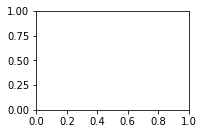

In [11]:
for epoch in tqdm.tnrange(epochs):
    random.shuffle(training_set_keys)

    batch = ()

    for key in tqdm.tqdm_notebook(training_set_keys, leave = False):
        i = random.randint(0, training_set[key].shape[1] - 80)
        batch += (training_set[key][32 : 93, i : i + 80],)

        if len(batch) == batch_size:
            batch = waveCRF.model.xp.array(batch)

            waveCRF.train(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

            batch = ()

    for key in tqdm.tqdm_notebook(test_set, leave = False):
        batch = waveCRF.model.xp.array((test_set[key][32 : 93],))

        waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

    IPython.display.clear_output()

    for i, key in enumerate(waveCRF.log):
        matplotlib.pyplot.subplot(221 + i)
        matplotlib.pyplot.plot(numpy.array(waveCRF.log[key]).reshape(epoch + 1, -1).mean(1))
        matplotlib.pyplot.xlabel('iteration')
        matplotlib.pyplot.ylabel(key)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    os.makedirs('{}/Models/WaveCRF/{}'.format(root, epoch))
    waveCRF.save('{}/Models/WaveCRF/{}'.format(root, epoch))

**Test (50 points)**  

* Generate a number of samples, pick the best one and play it in the notebook. **50 points**

In [5]:
import sys
sys.path
sys.path.append('./midi')
import midi.utils
import numpy as np
import tqdm
import pickle

#open model and save it
#get output for one batch 
#take the probabilities from the dimension with 2
#first probability: probability that note is not played (check this)
#second probability: probability that note is played (check this)
#generate random number: if it's higher than first probability number the note is played
#do this for all 61 notes to generate new timestamp vector
#concatinate this vector to the input that was given in the first place
#repeat multiple time

with open('test_set.pkl', 'rb') as f:
        test_set = pickle.load(f)

piano_roll = np.random.rand(61, 79) < .5
midi.utils.midiwrite('piano_roll.mid', piano_roll.T, (32, 93), 0.25) 
#test_set = np.load('test_set.npy')
print(len(test_set))
# Test

for key in test_set:
    batch = waveCRF.model.xp.array((test_set[key][32 : 93],))
    print(batch.shape)
    output = waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))
    print(output.shape)
'''
for key in tqdm.tqdm_notebook(test_set, leave = False):
    
    batch = waveCRF.model.xp.array((test_set[key][32 : 93],))
    print(batch)
    output = waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))
    sounds = output.array
    #print(sounds.shape)
    
    for i in (range(sounds.shape[3])):
        print(sounds[:,:,:,i])
    #midi.utils.midiwrite('piano_roll.mid', piano_roll.T, (32, 93), 0.25) 
'''    
    


363


NameError: name 'waveCRF' is not defined

**Bonus question (30 points)**

* _Discuss how you can improve the model (you can talk about different architectures or different ways to encode the inputs, etc.) **10 points*_*

* _Discuss the assumptions behind the meanfield approximation and its shortcomings. **10 points*_*

The assumption of the mean field approximation is that the probability of a series of notes occuring together, is the same as the joint probablity of each note occuring seperately. This assumption is somewhat naive, since there are certain combination of notes that sounds very melodic together while others combinations might not sound nice at all. Thus knowing that one note occurs can change the probability of another note occuring at the same time. 
However making this assumption also saves a lot of computational power since one doesn't have to worry about all possible conditional probabilites that may exist between notes.  

* _Prove that the iterative update equation (CRF-RNN component) is differentiable so that we can backpropagate through them. **10 points*_*